# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

It is strongly recommended to use Google Colab (with a GPU) to run this notebook. This will drastically speed up computations.

In [ ]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import tensorflow as tf
from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers.legacy import SGD
from keras.optimizers.schedules import ExponentialDecay
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from IPython.display import Image

In [ ]:
# This code will output the number of GPUs available. If you have a GPU installed and configured correctly, it should show a number greater than zero.
print("Number of GPUs available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPUs available:  1


# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Visualize convolutions](#first_cnn)<br>
- [3.2 Create your first CNN](#first_cnn)<br>
- [3.3 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.4 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

In [ ]:
# Dowloading the dataset
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


**Check the dimension of x_train and x_test.**

---

**What is the length of the train set? What is the shape of every image?**

---

In [ ]:
from keras.datasets import cifar10

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Length of the train set
length_trainset = len(x_train)

# Shape of every image
shape_image = x_train[0].shape

print("The length of the train set is", length_trainset)
print("The shape of the images is", shape_image)

The length of the train set is 50000
The shape of the images is (32, 32, 3)


**Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [ ]:
# Define the list of labels
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

**Scale images from [0,255] to be [0,1] (scaling usually improves model training).**

In [ ]:
# Scale images from [0,255] to [0,1]
x_train = x_train / 255.0
x_test = x_test / 255.0

**Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [ ]:
from keras.utils import to_categorical

# Convert target arrays to one-hot encodings
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

**Display the first image in the dataset using the `imshow()` function in `matplotlib.pyplot`.**

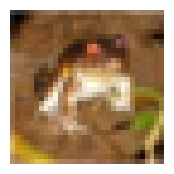

In [ ]:
import matplotlib.pyplot as plt

# Display the first image in the dataset
plt.figure(figsize=(2, 2))
plt.imshow(x_train[0])
plt.axis('off')  # Turn off axis
plt.show()

The following code allows to visualize 8 images in each category

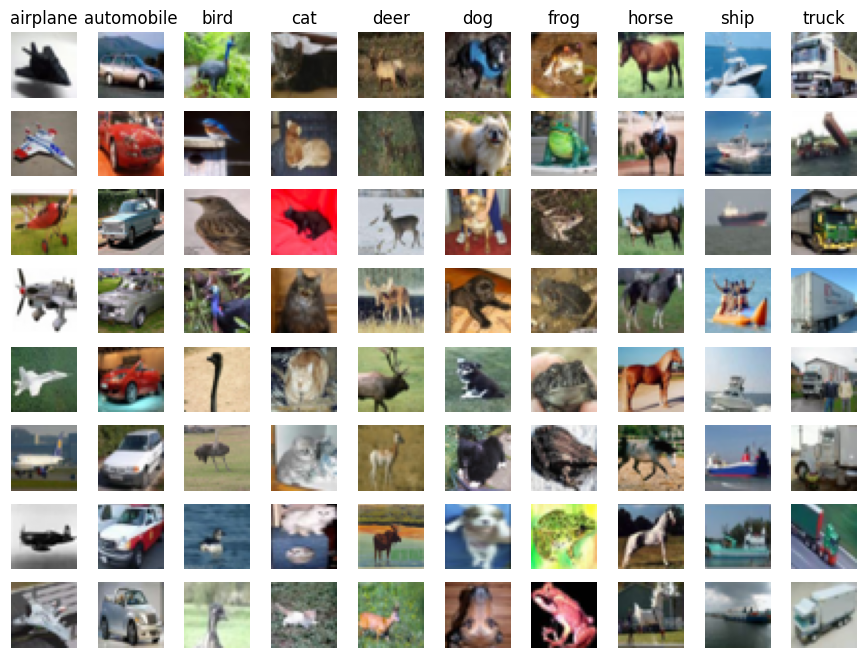

In [ ]:
n, images, categories, labels = 8, x_train, y_train, labels

f, axes = plt.subplots(n, 10, figsize=(11,8))

for i in range(10):
    count = 0
    j = 0
    while count < n and j < 50000:
        if categories[j][i] == 1:
            axes[count,i].imshow(images[j,:,:,:])
            axes[count,i].axis('off')
            if count == 0:
                axes[count,i].set_title(labels[i])
            count += 1
        j += 1
plt.show()


<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**Create a sequential model with 4 `Dense` hidden layers of 1024, 512, 256, and 100 nodes each, with ReLU activation, and an output layer suited for the learning task.**

In [ ]:
def dense_model(input_shape=(32,32,3), num_classes=10):
    model = Sequential()

    # Build the model sequentially using model.add(the layer you want to add)
    # You need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D

    # Flatten the input
    model.add(Flatten(input_shape=input_shape))

    # Add the dense layers
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(100, activation='relu'))

    # Add the output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = dense_model()

**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

**Detailed computations here:**

*Input Shape*: The model accepts an input shape corresponding to the CIFAR-10 images, which is (32, 32, 3). This is because the CIFAR-10 dataset consists of 32x32 pixel images with 3 channels (RGB).

*First Dense Layer*: The input is flattened to a vector of 3072 features (32 * 32 * 3). This flattened input is then fed into the first dense layer with 1024 neurons.
Weights: 3072 (input features) * 1024 (neurons) = 3,145,728
Biases: 1024 (one bias per neuron)

*Second Dense Layer*: This layer has 512 neurons and receives input from the first dense layer.
Weights: 1024 (neurons in the first layer) * 512 (neurons) = 524,288
Biases: 512

*Third Dense Layer*: This layer has 256 neurons.
Weights: 512 (neurons in the second layer) * 256 (neurons) = 131,072
Biases: 256

*Fourth Dense Layer*: This layer has 100 neurons.
Weights: 256 (neurons in the third layer) * 100 (neurons) = 25,600
Biases: 100

*Output Layer*: The final layer has 10 neurons, one for each class, with a softmax activation function to output a probability distribution over the 10 classes.
Weights: 100 (neurons in the fourth layer) * 10 (output features) = 1,000
Biases: 10 (one bias per output neuron)

**Adding them up:**
Total Parameters = 3146752 + 524800 + 131328 + 25700 + 1010 = 3,829,590 parameters.

In [ ]:
# Define the parameters for each layer
params_layer1 = 32 * 32 * 3 * 1024 + 1024  # Layer 1
params_layer2 = 1024 * 512 + 512  # Layer 2
params_layer3 = 512 * 256 + 256  # Layer 3
params_layer4 = 256 * 100 + 100  # Layer 4
params_output_layer = 100 * 10 + 10  # Output layer

# Calculate total parameters
total_number_parameters_dense = (params_layer1 + params_layer2 + params_layer3 + params_layer4 + params_output_layer)

print("Total trainable parameters in the model:", total_number_parameters_dense)

Total trainable parameters in the model: 3829590


**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [ ]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 100)               25700     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
Total params: 3829590 (14.61 MB)
Trainable params: 38295

Our manual computations correspond with the model summary.

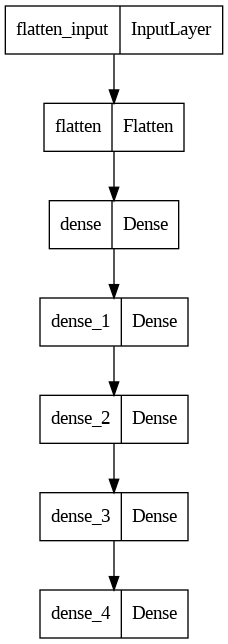

In [ ]:
# Use the following code to visualize your model
plot_model(model, to_file='model.png')
Image(filename='model.png')

**In the next function, you will:**

**a) Define a SGD optimizer. Specify the initial learning rate (that's up to you) and use an exponential decay with factor 0.9, using keras.optimizers.schedules.ExponentialDecay().**

**b) compile the model using model.compile(), specifying the optimizer, the loss and metrics=['accuracy']**

**c) fit the model on the train set. Define a stop_early callback method, monitoring the validation accuracy. Use history = model.fit(...) to keep track of the train/validation losses. Use 20% of the train data as a validation set**

**d) return the training history**

In [ ]:
def train_model(model,x_train, y_train, batch_size=32,epochs=10):
  # a) Define a SGD optimizer with exponential decay
  lr_schedule = ExponentialDecay(
      initial_learning_rate=0.01,  # Starting learning rate
      decay_steps=10000,          # After how many steps to apply decay
      decay_rate=0.9              # Decay factor
  )
  optimizer = SGD(learning_rate=lr_schedule)

  # b) Compile the model
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
                metrics=['accuracy'])

  # c) Define a stop_early callback method
  stop_early = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto')

  # Fit the model on the train set and use 20% of it as a validation set
  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=[stop_early])

  # Find the accuracy of the best model
  best_model_accuracy = history.history['val_accuracy'][np.argmin(history.history['val_loss'])]
  print("The accuracy of the final network is ", np.round(best_model_accuracy, decimals=3))

  return history

**What is the reason for using a scheduler?**

Using a learning rate scheduler like `ExponentialDecay` can help in training neural networks more efficiently. Indeed, with a decreasing learning rate, the model can potentially reach a good solution faster. It gradually decreases the learning rate over time, allowing larger updates at the start of training and smaller updates as the model approaches convergence. This adaptive adjustment helps prevent overshooting the optimal solution and improves the stability and performance of the model during training.   

Moreover, by scheduling the learning rate to decrease over time, you can ensure that the optimization process is more stable. Initially, using a larger learning rate allows for faster convergence, while later decreasing it ensures that the model fine-tunes more delicately, potentially finding better optima and preventing such overshooting or oscillations.

**Train the model. Compare the train loss and the validation loss at the first epoch. Did you expect such a result? Provide your comments, if any.**

At the first epoch, we see that the validation loss is actually lower than the training loss. Usually, the validation loss is higher than the training loss meaning that the model is fitting well on the training data but is finding it slightly more challenging to generalize to unseen data.

The validation happens after the training of each epoch and our weights are initialized randomly and so this not a surprising phenomenon

The model is beginning to learn from the data, and its parameters are being updated to minimize the loss. However, the model seems to get better at each epoch, reducing the gap between training and validation loss and we see that both training and validation loss decrease.

We need to be careful to not overfit by making sure the validation loss suddenly doesn't start increasing.

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
history = train_model(model,x_train, y_train)

Epoch 1/10
1250/1250 [==============================] - 7s 4ms/step - loss: 1.8943 - accuracy: 0.3154 - val_loss: 1.7824 - val_accuracy: 0.3687
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6860 - accuracy: 0.3949 - val_loss: 1.6873 - val_accuracy: 0.3996
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6007 - accuracy: 0.4293 - val_loss: 1.6356 - val_accuracy: 0.4210
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5354 - accuracy: 0.4508 - val_loss: 1.5654 - val_accuracy: 0.4462
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4861 - accuracy: 0.4706 - val_loss: 1.5587 - val_accuracy: 0.4502
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4379 - accuracy: 0.4860 - val_loss: 1.4905 - val_accuracy: 0.4708
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4006 - accuracy: 0.5022 - val_loss: 1.5417 - val_accuracy:

**Compute the predicted classes on the test set (hint: use model.predict() and keep the argmax). Compute the accuracy on the test set.**

In [ ]:
# Compute the output probability score
predict_x = model.predict(x_test)

# Compute the hard predictions using np.argmax
classes_x = np.argmax(predict_x, axis=1)

# One-hot encode the hard predictions using to_categorical
y_pred = to_categorical(classes_x, num_classes =10)

# Compute the accuracy by comparing the predicted classes to the true classes
#true_classes = np.argmax(y_test, axis=1)
#acc = np.mean(classes_x == true_classes)


# Compute the accuracy
acc = model.evaluate(x_test, y_test)
print("The accuracy on the test set is", acc[1] )

313/313 [==============================] - 1s 3ms/step - loss: 1.3850 - accuracy: 0.5046
The accuracy on the test set is 0.5045999884605408


**Plot eight images in each category, and check the corresponding predictions. Provide your comments, if any (Hint: Copy paste and adapt the code provided above to display the first eight images per category).**

1/1 [==============================] - 0s 25ms/step


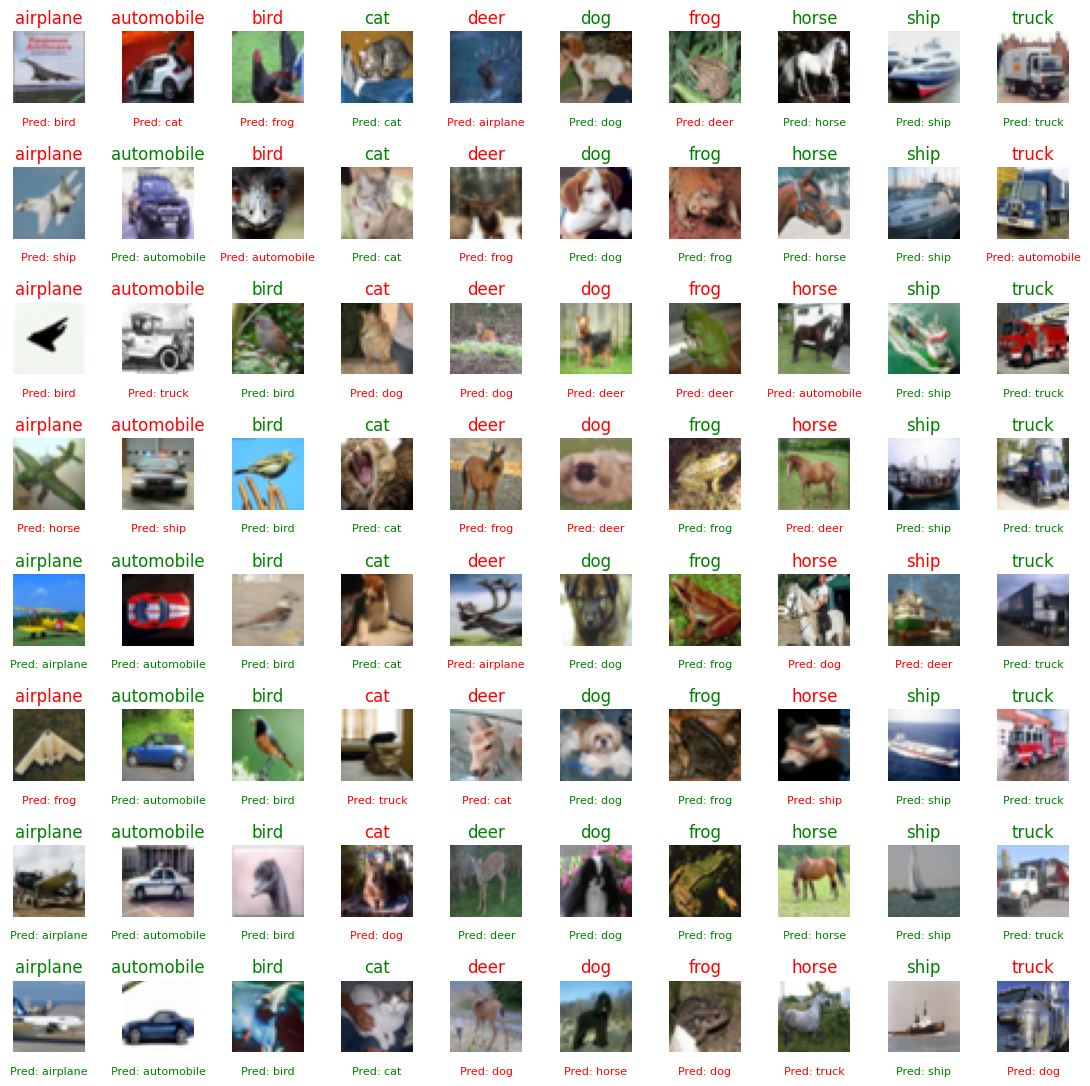

In [ ]:
n, images, categories, labels = 8, x_test, y_test, labels

f, axes = plt.subplots(n, 10, figsize=(11, 11))

for i in range(10):
    count = 0
    j = 0
    while count < n and j < len(images):
        if categories[j][i] == 1:  # Check if the image belongs to the current category i
            axes[count, i].imshow(images[j])
            axes[count, i].axis('off')

            # Get the model's prediction for the image
            predicted_class = np.argmax(model.predict(np.expand_dims(images[j], axis=0)))

            # Compare the predicted class with the true class
            true_class = np.argmax(categories[j])  # Convert one-hot encoded category to class index

            # Set the title to display the true class label
            axes[count, i].set_title(labels[true_class], color='green' if predicted_class == true_class else 'red')

            # Set the xlabel to display the predicted class label on top of the image
            axes[count, i].text(0.5, -0.3, 'Pred: ' + labels[predicted_class],
                                color='green' if predicted_class == true_class else 'red',
                                transform=axes[count, i].transAxes, ha='center', size=8)
            count += 1
        j += 1
plt.tight_layout()
plt.show()

<a id='cnn'></a>

# 3 - Convolutional Neural Network


Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='handcrafted features'></a>
## 3.1 - Visualize 2D-convolution of an image

We will first investigate the effect of using a convolutional layer on the image, with a single filter/kernel applied to each color channel. The following functions allows to define a taylored convolutional layer, and to vizualize the output. Nothing is required from your side, just run the cell.


In [ ]:
def handcrafted_Conv2D(kernels,input_shape = (32,32,3),activation = None):

  filters = len(kernels)
  kernel_size = kernels[0].shape

  model = Sequential()
  model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=input_shape))

  # Create the 3D kernel by repeating the 2D kernel for each color channel
  kernels_3d = []
  for kernel in kernels:
    kernels_3d.append(np.stack([kernel] * 3, axis=-1).reshape(3,3,3,1))
  kernels_3d = np.concatenate(kernels_3d,axis=-1)

  model.set_weights([kernels_3d,np.zeros(filters)])
  model.layers[0].trainable = False

  return model


def plot_output_sample(model,kernel=None,image_index=115):

  image = x_train[image_index]
  convolved_image = model(image.reshape(1,32,32,3))
  plt.figure(figsize=(8, 4))

  if kernel is None:
    plots = 2
  else:
    plots = 3

  # Original Image
  plt.subplot(1, plots, 1)
  plt.title('Original Image')
  plt.imshow(image)
  plt.axis('off')

  if kernel is not None:
    plt.subplot(1, 3, 2)
    plt.title('Kernel')
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')

  # Convolved Image
  plt.subplot(1, plots, plots)
  plt.title('Output image')
  plt.imshow(convolved_image[0], cmap='gray')
  plt.axis('off')
  plt.show()


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)




**Define your own kernel of shape (3,3), specialized in the detection of horizontal lines in an image**

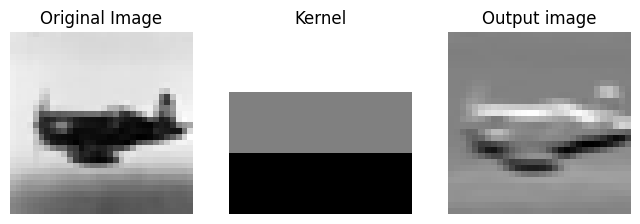

In [ ]:
import numpy as np

# Define the kernel for detecting horizontal lines
kernel = np.array([[1, 1, 1],
                   [0, 0, 0],
                   [-1, -1, -1]])

model = handcrafted_Conv2D([kernel])
plot_output_sample(model,kernel)

**Same question, but this time use a kernel specialized in the detection of vertical lines**

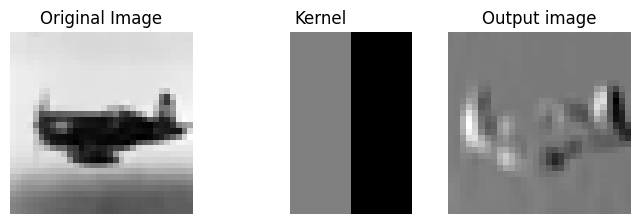

In [ ]:
# Define the kernel for detecting vertical lines
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

model = handcrafted_Conv2D([kernel])
plot_output_sample(model,kernel)

**The following cell allows to vizualise the effect of various filters on the image. Comment on the effect of the filters that are used**

1. Top filter

This filter is designed to detect top edges in an image. It's particularly effective at identifying horizontal edges where the top part of an object contrasts with the bottom part. The positive values in the center row amplify the contrast between the top and bottom parts of the object, while the negative values in the top row enhance the detection of the top edge.

2. Straight filter

Straights (Horizontal, Vertical, and Diagonal Lines) Filters (straights):
These filters are rotations of the top filter, capturing straight lines in different orientations. By rotating the top filter 90 degrees clockwise four times, we obtain filters for detecting horizontal, vertical, and two diagonal lines.

- Horizontal Line Detection Filter: Represents horizontal lines in an image.
- Vertical Line Detection Filter: Represents vertical lines in an image.
- Two Diagonal Line Detection Filters: Represent diagonal lines in an image, with each filter detecting lines slanting in different directions.

3. Bottom-Right filter

This filter is designed to detect edges running from the bottom-right to the top-left direction in an image. It's particularly effective at identifying diagonal edges where one side of the edge is brighter than the other. The positive diagonal from bottom-left to top-right enhances the detection of the edge, while the negative diagonal from bottom-right to top-left suppresses irrelevant features.

4. Diagonal Edge filter:

These filters are rotations of the Bottom-Right filter, capturing diagonal edges in different orientations. By rotating the br filter 90 degrees clockwise four times, we obtain filters for detecting diagonal edges in various directions.




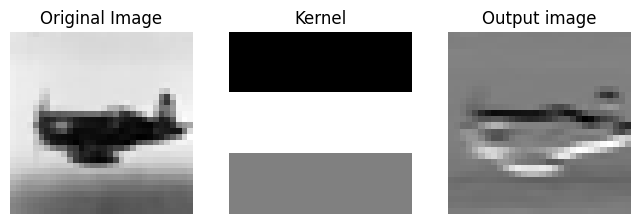

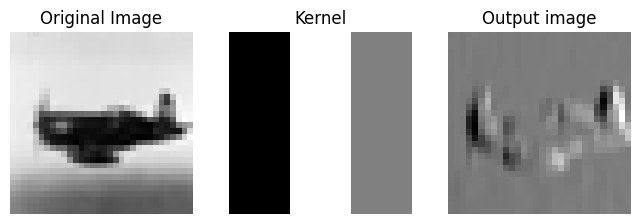

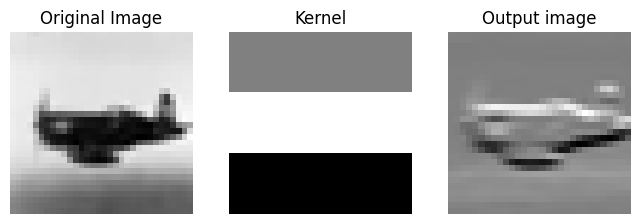

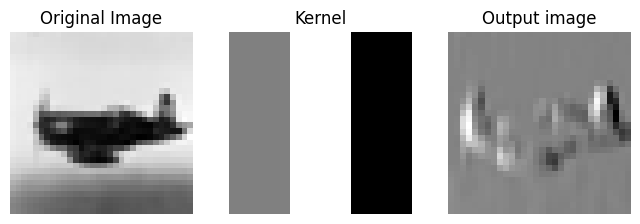

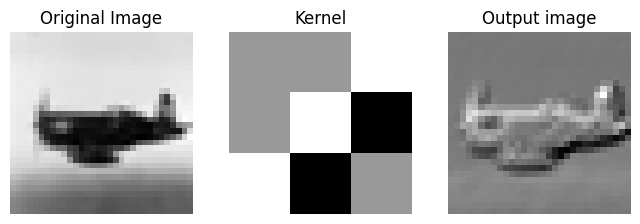

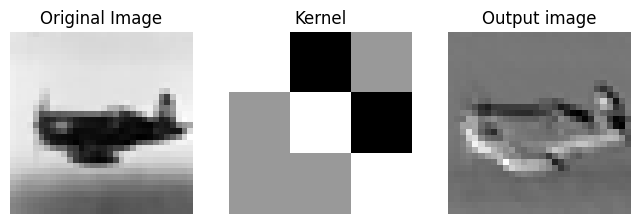

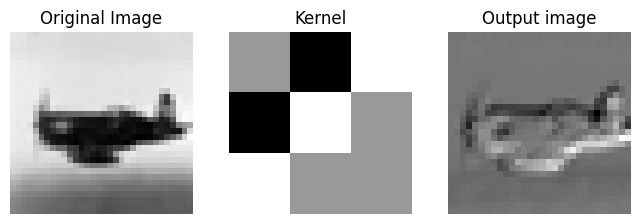

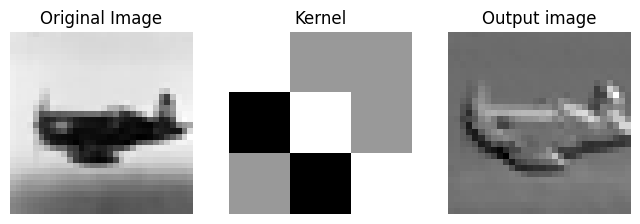

Effect of the filters:
- The 'straights' kernels detect horizontal and vertical edges in the image.
- The 'diags' kernels detect diagonal edges in the image.


In [ ]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]

straights = [ np.rot90(top,i) for i in range(4) ]

br=[[ 0,   0,   1],
    [ 0,   1,-1.5],
    [ 1,-1.5,   0]]

diags = [np.rot90(br,i) for i in range(4)]

kernels = straights+diags

for kernel in kernels:
    # Create a model with the current kernel
    model = handcrafted_Conv2D([kernel])

    # Visualize the effect of the current kernel on the image
    plot_output_sample(model, kernel)

# Comment on the effect of the filters
print("Effect of the filters:")
print("- The 'straights' kernels detect horizontal and vertical edges in the image.")
print("- The 'diags' kernels detect diagonal edges in the image.")


In [ ]:
# Output the kernels used
kernels

[array([[-1, -1, -1],
        [ 1,  1,  1],
        [ 0,  0,  0]]),
 array([[-1,  1,  0],
        [-1,  1,  0],
        [-1,  1,  0]]),
 array([[ 0,  0,  0],
        [ 1,  1,  1],
        [-1, -1, -1]]),
 array([[ 0,  1, -1],
        [ 0,  1, -1],
        [ 0,  1, -1]]),
 array([[ 0. ,  0. ,  1. ],
        [ 0. ,  1. , -1.5],
        [ 1. , -1.5,  0. ]]),
 array([[ 1. , -1.5,  0. ],
        [ 0. ,  1. , -1.5],
        [ 0. ,  0. ,  1. ]]),
 array([[ 0. , -1.5,  1. ],
        [-1.5,  1. ,  0. ],
        [ 1. ,  0. ,  0. ]]),
 array([[ 1. ,  0. ,  0. ],
        [-1.5,  1. ,  0. ],
        [ 0. , -1.5,  1. ]])]

We will use these features as a preprocessing.

**Define a model with the previous handcrafted fixed convolutionals layers as a preprocessing. Add a MaxPooling2D layer. Flatten the result and add a final dense layer with softmax activation**

In [ ]:
def manual_features_model(kernels, input_shape=(32,32,3), num_classes=10):
    model = Sequential()

    model = handcrafted_Conv2D(kernels, activation = "relu")

    # Add MaxPooling2D layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the result
    model.add(Flatten())

    # Add final dense layer with softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = manual_features_model(kernels)
model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 8)         0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 1800)              0         
                                                                 
 dense_5 (Dense)             (None, 10)                18010     
                                                                 
Total params: 18234 (71.23 KB)
Trainable params: 18010 (70.35 KB)
Non-trainable params: 224 (896.00 Byte)
_________________________________________________________________


**Train the model and provide your comments**

The training and validation loss are decreasing consistently over epochs, which indicates the model is learning and improving its predictions on both the training and unseen validation data. The validation accuracy plateaus slightly around 51%, suggesting potential beginning of overfitting, underfitting, or that the model has reached its capacity with the current architecture and hyperparameters.

In [ ]:
history = train_model(model,x_train, y_train)

Epoch 1/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7567 - accuracy: 0.3864 - val_loss: 1.5847 - val_accuracy: 0.4512
Epoch 2/10
1250/1250 [==============================] - 3s 3ms/step - loss: 1.5097 - accuracy: 0.4811 - val_loss: 1.5238 - val_accuracy: 0.4785
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4375 - accuracy: 0.5090 - val_loss: 1.4955 - val_accuracy: 0.4880
Epoch 4/10
1250/1250 [==============================] - 3s 3ms/step - loss: 1.3937 - accuracy: 0.5246 - val_loss: 1.4685 - val_accuracy: 0.4990
Epoch 5/10
1250/1250 [==============================] - 3s 3ms/step - loss: 1.3623 - accuracy: 0.5395 - val_loss: 1.4530 - val_accuracy: 0.5070
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3381 - accuracy: 0.5478 - val_loss: 1.4356 - val_accuracy: 0.5106
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3182 - accuracy: 0.5531 - val_loss: 1.4315 - val_accuracy:

<a id='first_cnn'></a>
## 3.2 - Create your first CNN

**Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero-padding, a stride of 1, 8 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, a stride of 1, 8 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - 3x3 2D convolution, with zero-padding, a stride of 1, 32 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, a stride of 1, 32 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - Flatten
  - Dense layer with 408 nodes, ReLU activation
  - A well-chosen output layer

In [ ]:
def CNN(input_shape=(32,32,3), num_classes=10):
  model = Sequential()
  model.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=input_shape))
  model.add(Conv2D(8, (3, 3), padding='valid', strides=(1, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='relu'))
  model.add(Conv2D(32, (3, 3), padding='valid', strides=(1, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Flatten())
  model.add(Dense(408, activation='relu'))

  # Output layer
  model.add(Dense(num_classes, activation='softmax'))

  return model

# Create the model
model = CNN()

**Compute by hand the number of trainable parameters in this network.  Are there more or less than the simple dense network of section 1?  Why?**

1. **Conv2D Layer 1**:
   - Filters: 8
   - Kernel size: (3, 3)
   - Trainable parameters: (3 * 3 * 3 * 8) + 8 = 224

2. **Conv2D Layer 2**:
   - Filters: 8
   - Kernel size: (3, 3)
   - Trainable parameters: (3 * 3 * 8 * 8) + 8 = 584

3. **MaxPooling2D Layer 1**:
   - No trainable parameters.

4. **Conv2D Layer 3**:
   - Filters: 32
   - Kernel size: (3, 3)
   - Trainable parameters: (3 * 3 * 8 * 32) + 32 = 2336

5. **Conv2D Layer 4**:
   - Filters: 32
   - Kernel size: (3, 3)
   - Trainable parameters: (3 * 3 * 32 * 32) + 32 = 9248

6. **MaxPooling2D Layer 2**:
   - No trainable parameters.

7. **Flatten Layer**:
   - No trainable parameters.

8. **Dense Layer**:
   - Input size: 1152 (flattened from the previous layer)
   - Output size: 408
   - Trainable parameters: (1152 * 408) + 408 = 470424

9. **Output Dense Layer**:
   - Input size: 408
   - Output size: 10
   - Trainable parameters: (408 * 10) + 10 = 4090

Now, let's sum up the trainable parameters:

Total Parameters = 224 + 584 + 2336 + 9248 + 470424 + 4090 = 486,906 parameters

This is clearly a lot less than the 3 million parameters we had with the simple dense network previously.


In [ ]:
# Put here the result of your computation
total_number_parameters_cnn = 486_906


 **Confirm with `summary()`. Finally, display the model using plot_model()**

In [ ]:
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 15, 15, 32)        2336      
                                                                 
 conv2d_14 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                

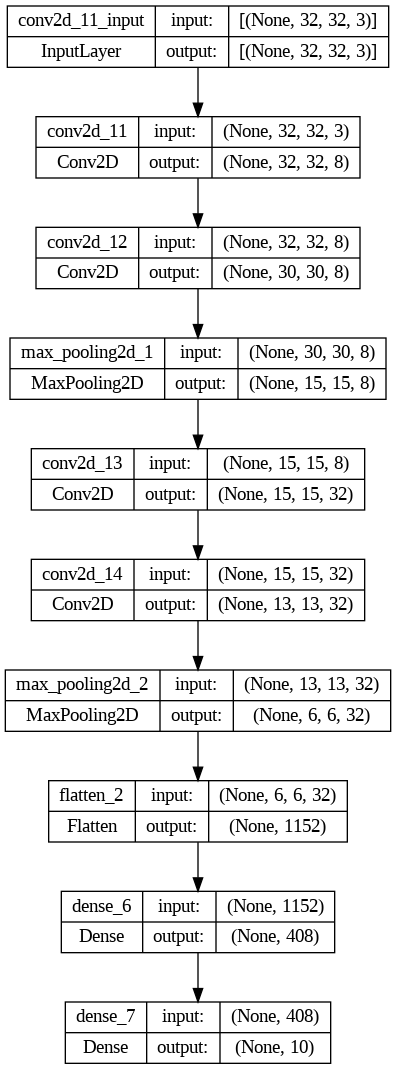

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)



**Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

In [ ]:
history = train_model(model,x_train,y_train)

Epoch 1/10
1250/1250 [==============================] - 7s 5ms/step - loss: 2.0184 - accuracy: 0.2701 - val_loss: 1.7368 - val_accuracy: 0.3894
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6333 - accuracy: 0.4189 - val_loss: 1.5405 - val_accuracy: 0.4544
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4475 - accuracy: 0.4838 - val_loss: 1.3887 - val_accuracy: 0.5108
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3199 - accuracy: 0.5314 - val_loss: 1.3748 - val_accuracy: 0.5136
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2206 - accuracy: 0.5700 - val_loss: 1.2128 - val_accuracy: 0.5732
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1371 - accuracy: 0.6015 - val_loss: 1.1966 - val_accuracy: 0.5827
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0607 - accuracy: 0.6291 - val_loss: 1.1440 - val_accuracy:

The trend here is generally positive, with the model accuracy on the validation set increasing as training progresses.  

With our new CNN, we make more progress reaching an accuracy over 0.62 on the validation set when our maximum accuracy was 0.52 so far.

<a id='cnn_parameters'></a>
## 3.3 - Influence of parameters on the performance

**How does the performance depend on batch size? Train different models with different batch_size**

The model's performance appears to depend significantly on the batch size, showing a trend where accuracy decreases as the batch size increases. A possible explanation for this behavior is that smaller batch sizes provide more frequent updates to the model parameters, allowing for a more refined and possibly more accurate search in the parameter space.


In [ ]:
# Make sure to reinitialize the model before training on a new batch size!

history_1 = train_model(CNN(), x_train, y_train, batch_size=16)
history_2 = train_model(CNN(), x_train, y_train, batch_size=32)
history_3 = train_model(CNN(), x_train, y_train, batch_size=64)
history_4 = train_model(CNN(), x_train, y_train, batch_size=128)
history_5 = train_model(CNN(), x_train, y_train, batch_size=256)

Epoch 1/10
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8726 - accuracy: 0.3254 - val_loss: 1.7103 - val_accuracy: 0.3929
Epoch 2/10
2500/2500 [==============================] - 9s 3ms/step - loss: 1.4667 - accuracy: 0.4713 - val_loss: 1.3891 - val_accuracy: 0.5038
Epoch 3/10
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2850 - accuracy: 0.5405 - val_loss: 1.2444 - val_accuracy: 0.5641
Epoch 4/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.1499 - accuracy: 0.5939 - val_loss: 1.1715 - val_accuracy: 0.5871
Epoch 5/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.0426 - accuracy: 0.6335 - val_loss: 1.0980 - val_accuracy: 0.6164
Epoch 6/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.9484 - accuracy: 0.6675 - val_loss: 1.0950 - val_accuracy: 0.6217
Epoch 7/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.8633 - accuracy: 0.6985 - val_loss: 1.0078 - val_accurac

**Provide any pyplot graphic that you find useful to compare the influence of minibatch_size on the performance.**

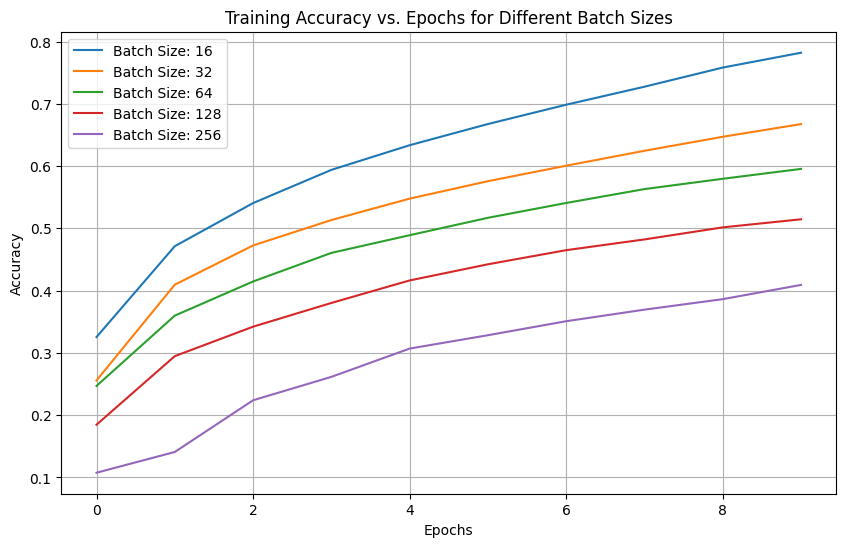

In [ ]:
# Training histories for different batch sizes
histories = [history_1, history_2, history_3, history_4, history_5]
batch_sizes = [16, 32, 64, 128, 256]

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Batch Size: {batch_sizes[i]}')
plt.title('Training Accuracy vs. Epochs for Different Batch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Consider now a batch size of 32 and consider the above CNN. Try adding 3 BatchNormalization layers to this model, one after each max-pooling layer and one before the last layer.**

In [ ]:
def CNN_with_BatchNorm(input_shape=(32,32,3), num_classes=10):
    model = Sequential()
    model.add(Conv2D(8, (3, 3), padding='same', strides=(1, 1), activation='relu', input_shape=input_shape))
    model.add(Conv2D(8, (3, 3), padding='valid', strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(408, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create and train the model
model = CNN_with_BatchNorm()
history = train_model(model, x_train, y_train)

history.history['val_accuracy'][np.argmin(history.history['val_loss'])]


Epoch 1/10
1250/1250 [==============================] - 10s 7ms/step - loss: 1.5950 - accuracy: 0.4423 - val_loss: 1.3686 - val_accuracy: 0.5219
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2140 - accuracy: 0.5703 - val_loss: 1.2286 - val_accuracy: 0.5669
Epoch 3/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.0752 - accuracy: 0.6237 - val_loss: 1.2624 - val_accuracy: 0.5638
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9765 - accuracy: 0.6587 - val_loss: 1.0839 - val_accuracy: 0.6279
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9002 - accuracy: 0.6864 - val_loss: 1.0560 - val_accuracy: 0.6375
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8370 - accuracy: 0.7074 - val_loss: 1.0112 - val_accuracy: 0.6546
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7754 - accuracy: 0.7295 - val_loss: 1.0911 - val_accuracy

0.6690000295639038

**What is the impact of batch normalization on the model's performance? Why?**


Using batch normalization increased significantly our performance when using default batch size of 32.

Batch normalization helps stabilize the gradients during backpropagation by reducing the scale of the gradients. This can alleviate the vanishing gradient problem, allowing for deeper networks to be trained more effectively. Moreover, it acts as a form of regularization by adding noise to the activations of each layer. This can help prevent overfitting and improve the generalization ability of the model.

It also reduces the sensitivity of the model to weight initialization. This means that the model is less dependent on careful initialization of weights, which can simplify the training process and make it less prone to getting stuck in local minima.




**Plot the evolution of (train/val) accuracy through epochs**

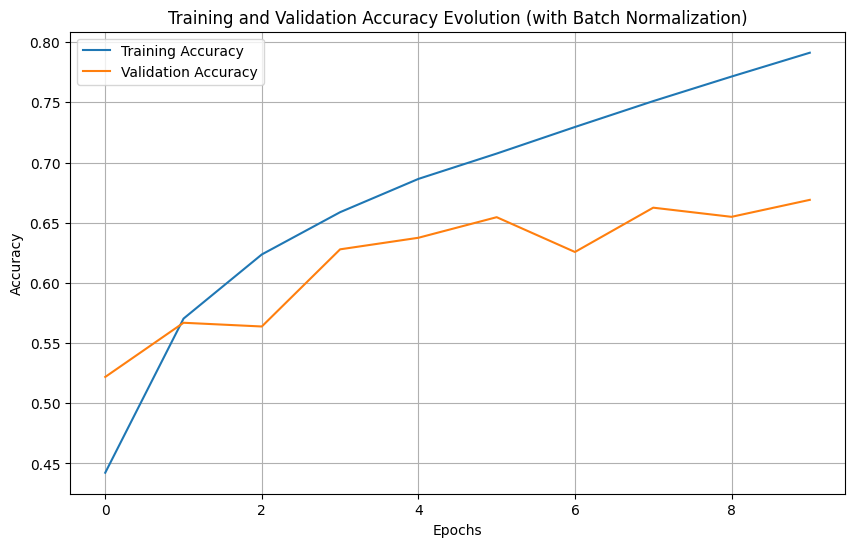

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Evolution (with Batch Normalization)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**Try changing the SGD optimizer to RMSProp and Adam, by redefining the train_model() function given previously. You might also need to modify the learning rate (try smaller learning rates). Provide your comments.**

In [51]:
from keras.optimizers import RMSprop, Adam

def train_model(model, x_train, y_train, optimizer='rmsprop', learning_rate=0.001, batch_size=32, epochs=10):
    if optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer =='sgd':
        lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9)
        optimizer = SGD(learning_rate=lr_schedule)
    else:
        raise ValueError("Invalid optimizer. Please choose 'rmsprop' or 'adam'.")

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    stop_early = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto')

    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=[stop_early])

    best_model_accuracy = max(history.history['val_accuracy'])
    print("The highest validation accuracy achieved by the final network is ", np.round(best_model_accuracy, decimals=3))

    return history

In [57]:
history_rmsprop = train_model(CNN_with_BatchNorm(), x_train, y_train, optimizer='rmsprop', learning_rate=0.0009)

Epoch 1/10
1250/1250 [==============================] - 10s 7ms/step - loss: 1.4155 - accuracy: 0.5094 - val_loss: 1.5715 - val_accuracy: 0.4914
Epoch 2/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.9758 - accuracy: 0.6591 - val_loss: 1.3496 - val_accuracy: 0.5506
Epoch 3/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.7886 - accuracy: 0.7240 - val_loss: 0.9671 - val_accuracy: 0.6683
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6457 - accuracy: 0.7752 - val_loss: 1.1474 - val_accuracy: 0.6481
Epoch 5/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.5278 - accuracy: 0.8170 - val_loss: 0.9625 - val_accuracy: 0.7013
Epoch 6/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4183 - accuracy: 0.8547 - val_loss: 0.9886 - val_accuracy: 0.7048
Epoch 7/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.3334 - accuracy: 0.8849 - val_loss: 1.2011 - val_accuracy

In [59]:
history_adam = train_model(CNN_with_BatchNorm(), x_train, y_train, optimizer='adam', learning_rate=0.001)

Epoch 1/10
1250/1250 [==============================] - 10s 6ms/step - loss: 1.3864 - accuracy: 0.5227 - val_loss: 1.1935 - val_accuracy: 0.5884
Epoch 2/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9596 - accuracy: 0.6643 - val_loss: 1.1947 - val_accuracy: 0.6111
Epoch 3/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.7977 - accuracy: 0.7203 - val_loss: 0.8989 - val_accuracy: 0.6851
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6697 - accuracy: 0.7677 - val_loss: 0.8995 - val_accuracy: 0.7006
Epoch 5/10
1250/1250 [==============================] - 11s 9ms/step - loss: 0.5352 - accuracy: 0.8156 - val_loss: 0.9653 - val_accuracy: 0.6958
Epoch 6/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4264 - accuracy: 0.8519 - val_loss: 1.1694 - val_accuracy: 0.6533
Epoch 7/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.3415 - accuracy: 0.8817 - val_loss: 1.0637 - val_accurac

The accuracy score is tight between our model using batch normalization with Adam optimizer and RMSprop. For the next question, we will use RMSprop as favorite model

**Plot the evolution of (train/val) accuracy through epochs**

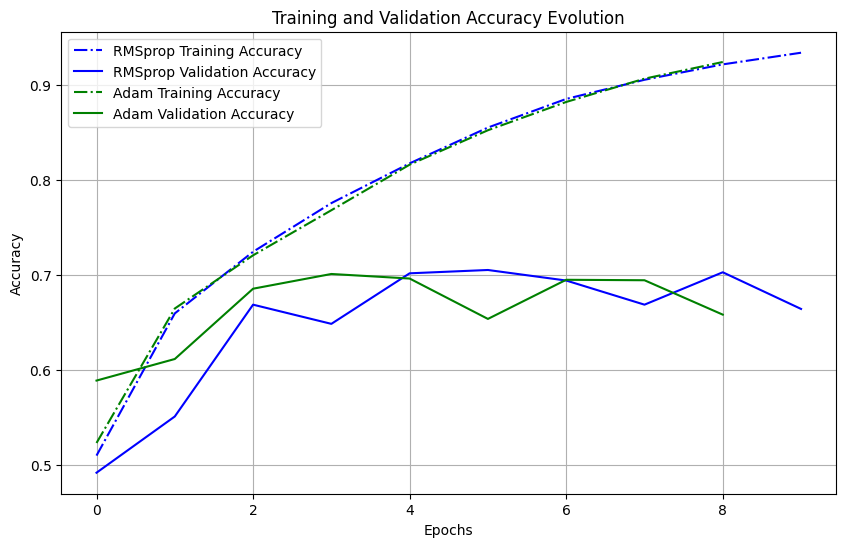

In [60]:
# Plot training and validation accuracy for both RMSprop and Adam on the same plot
plt.figure(figsize=(10, 6))

# RMSprop
plt.plot(history_rmsprop.history['accuracy'], label='RMSprop Training Accuracy', color='blue', linestyle='-.')
plt.plot(history_rmsprop.history['val_accuracy'], label='RMSprop Validation Accuracy', color='blue')

# Adam
plt.plot(history_adam.history['accuracy'], label='Adam Training Accuracy', color='green', linestyle='-.')
plt.plot(history_adam.history['val_accuracy'], label='Adam Validation Accuracy', color='green')

plt.title('Training and Validation Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


<a id='results'></a>

## 3.4 - Studying predictions

**Use your prefered model. Compute the accuracy on the test set**

In [55]:
model = CNN_with_BatchNorm()
history = train_model(model, x_train, y_train, batch_size=32,  optimizer='rmsprop', learning_rate=0.001)

# Compute the output probability score
predict_x= model.predict(x_test)

# Compute the hard predictions using np.argmax
classes_x= np.argmax(predict_x, axis=1)

# One-hot encode the hard predictions using to_categorical
y_pred = to_categorical(classes_x, num_classes=10)

# Compute the accuracy
acc = model.evaluate(x_test, y_test)
print("The accuracy on the test set is", acc[1] )

Epoch 1/10
1250/1250 [==============================] - 9s 6ms/step - loss: 1.4133 - accuracy: 0.5109 - val_loss: 1.2675 - val_accuracy: 0.5836
Epoch 2/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.9920 - accuracy: 0.6509 - val_loss: 1.1674 - val_accuracy: 0.6179
Epoch 3/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.7904 - accuracy: 0.7246 - val_loss: 0.9560 - val_accuracy: 0.6734
Epoch 4/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.6512 - accuracy: 0.7739 - val_loss: 0.9972 - val_accuracy: 0.6750
Epoch 5/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.5234 - accuracy: 0.8176 - val_loss: 1.5570 - val_accuracy: 0.5856
Epoch 6/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.4286 - accuracy: 0.8508 - val_loss: 1.0302 - val_accuracy: 0.7006
Epoch 7/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.3396 - accuracy: 0.8825 - val_loss: 1.1095 - val_accuracy:

**Consider image number 3 in the test set. Display the image and the output probabilities associated to each category**

1/1 [==============================] - 0s 232ms/step


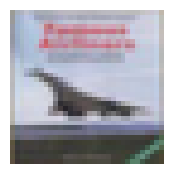


Sorted probabilities associated with each category:



,Class,Probability
0,airplane,7.713235e-01
1,automobile,2.174016e-01
9,truck,6.250685e-03
8,ship,3.599466e-03
2,bird,1.424519e-03
4,deer,2.067684e-07
7,horse,2.856564e-08
5,dog,9.054751e-10
6,frog,1.423936e-10
3,cat,5.460809e-12


In [ ]:
import pandas as pd
# Consider image number 3 in the test set
image = x_test[3]

# Reshape the image to add a batch dimension
image = np.expand_dims(image, axis=0)

# Predict the output probabilities associated with each category
y = model.predict(image)[0]

# Display the image
plt.figure(figsize=(2, 2))
plt.imshow(x_test[3])
plt.axis('off')
plt.show()

# Print the output probabilities associated with each category
d = {labels[i]: y[i] for i in range(10)}

# Create DataFrame from the dictionary
df = pd.DataFrame(list(d.items()), columns=['Class', 'Probability'])

# Sort DataFrame by probability in descending order
df = df.sort_values(by='Probability', ascending=False)

# Display the sorted DataFrame
print("\nSorted probabilities associated with each category:\n")
display(df)

**Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image below for few test images. Compute the accuracy of your model on the test set and comment.**

![Image](https://bianchi.wp.imt.fr/files/2024/02/categories-228x300.png)


NB: You can save the model after training it (function `save` in keras), and then decide to load from saved file instead of building a new one (if available) on successive runs (via the function `load_model` in keras).**

1/1 [==============================] - 0s 227ms/step
Accuracy on the test set: 1.0


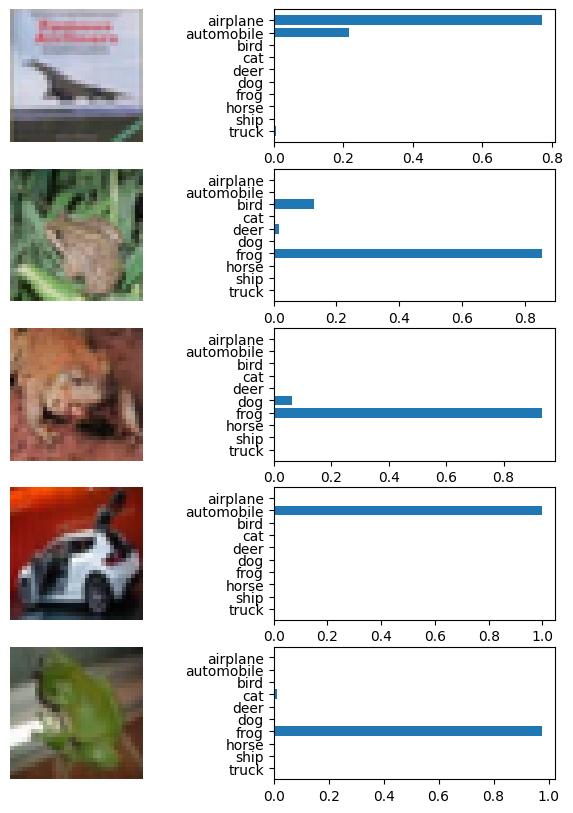

In [ ]:
def predict(model, x, labels, file_name=None):
    y = model.predict(x)

    f, ax = plt.subplots(x.shape[0], 2, figsize=(8, 2 * x.shape[0]))
    y_pos = np.arange(len(labels))

    for i in range(x.shape[0]):
        ax[i, 0].imshow(x[i])
        ax[i, 0].axis('off')
        ax[i, 1].barh(y_pos, y[i], align='center')
        ax[i, 1].set_yticks(y_pos)
        ax[i, 1].set_yticklabels(labels)
        ax[i, 1].invert_yaxis()  # Put labels in alphabetical order

    if file_name:
        plt.savefig(file_name, bbox_inches='tight')
    else:
        plt.show()

    return y

# Call the predict function to visualize predictions for a subset of test images
predictions = predict(model, x_test[3:8], labels, file_name="predictions.png")

# Compute accuracy on the test set
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test[3:8], axis=1)
accuracy = np.mean(predicted_labels == true_labels)
print("Accuracy on the test set:", accuracy)

We achieved an accuracy of 1.0 on this subset of 4 images. It suggests that the model is performing exceptionally well on this particular sample.

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement.

**Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

313/313 [==============================] - 1s 2ms/step


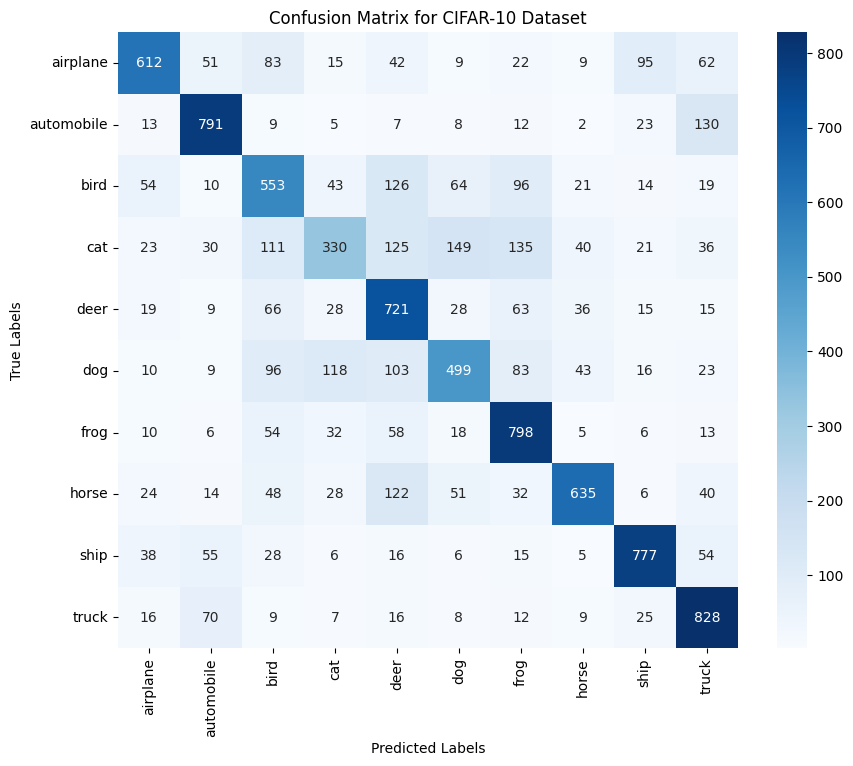

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Use the trained model to make predictions on the test data
predict_x = model.predict(x_test)

# Step 2: Convert the predicted labels and true labels to class labels
classes_x = np.argmax(predict_x, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Step 3: Construct the confusion matrix
conf_matrix = confusion_matrix(true_labels, classes_x)

# Step 4: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CIFAR-10 Dataset')
plt.show()

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks

Several pre-trained networks are directly accessible via keras.

**Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10.**

In [ ]:
# Import all usefull libraries
# A tutorial can be found here : https://www.tensorflow.org/tutorials/images/transfer_learning

from keras.applications import MobileNetV2
from keras.applications import DenseNet201
from skimage.transform import resize
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

def image_generator(images, labels, batch_size=32, target_size=(224, 224)):
    num_samples = len(images)
    while True:
        for i in range(0, num_samples, batch_size):
            batch_images = images[i:i+batch_size]
            batch_resized = tf.image.resize(batch_images, target_size)
            x_batch = np.array(batch_resized)
            y_batch = labels[i:i+batch_size]
            yield x_batch, y_batch


# Resize images to meet the input size requirement of MobileNetV2 (224x224)
# Create generators for training and validation data
train_generator = image_generator(x_train, y_train)
val_generator = image_generator(x_test, y_test)

In [ ]:
# Load pre-trained MobileNetV2 model without the top layer
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create the custom layers for our task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can experiment with the number of units
predictions = Dense(10, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define steps per epoch for both training and validation
steps_per_epoch = len(x_train) // 32
validation_steps = len(x_test) // 32

# Train the model using the generators
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10,
                    validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/10
1562/1562 [==============================] - 320s 192ms/step - loss: 0.5431 - accuracy: 0.8101 - val_loss: 0.4885 - val_accuracy: 0.8258
Epoch 2/10
1562/1562 [==============================] - 299s 188ms/step - loss: 0.3999 - accuracy: 0.8592 - val_loss: 0.4629 - val_accuracy: 0.8384
Epoch 3/10
1562/1562 [==============================] - 294s 188ms/step - loss: 0.3296 - accuracy: 0.8824 - val_loss: 0.4215 - val_accuracy: 0.8570
Epoch 4/10
1562/1562 [==============================] - 291s 186ms/step - loss: 0.2686 - accuracy: 0.9072 - val_loss: 0.4475 - val_accuracy: 0.8575
Epoch 5/10
1562/1562 [==============================] - 326s 209ms/step - loss: 0.2200 - accuracy: 0.9246 - val_loss: 0.5339 - val_accuracy: 0.8434
Epoch 6/10
1562/1562 [==============================] - 292s 187ms/step - loss: 0.1836 - accuracy: 0.9358 - val_loss: 0.6343 - val_accuracy: 0.8289
Epoch 7/10
1562/1562 [==============================] - 326s 209ms/step - loss: 0.1549 - accuracy: 0.9465 - val_

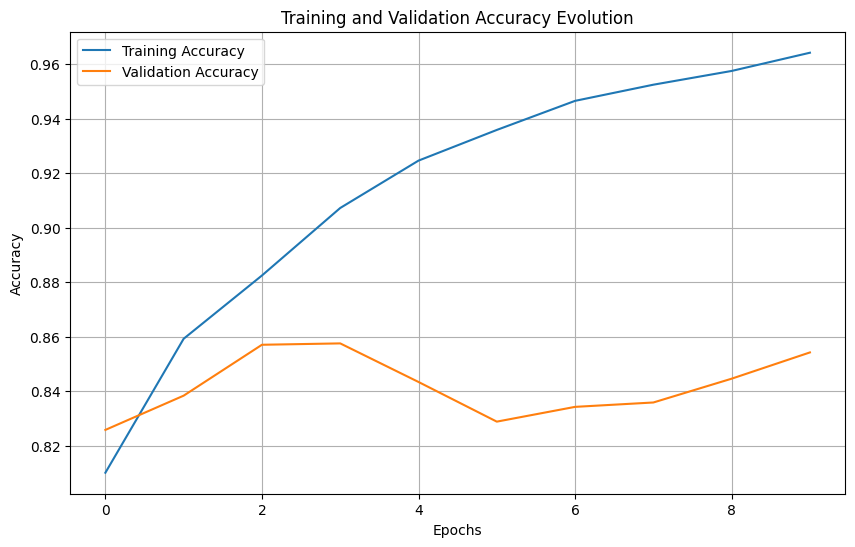

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Assuming the image_generator function is defined as before
test_generator = image_generator(x_test, y_test, batch_size=32, target_size=(224, 224))

# Calculate the number of steps for the entire test set
test_steps = len(x_test) // 32

# Evaluate the model using the test generator
loss, accuracy = model.evaluate(test_generator, steps=test_steps)
print("The accuracy on the test set is", accuracy)

312/312 [==============================] - 49s 158ms/step - loss: 0.7126 - accuracy: 0.8547
The accuracy on the test set is 0.8546674847602844


**Plot several images with their predictions. Any comment?**

1/1 [==============================] - 0s 38ms/step


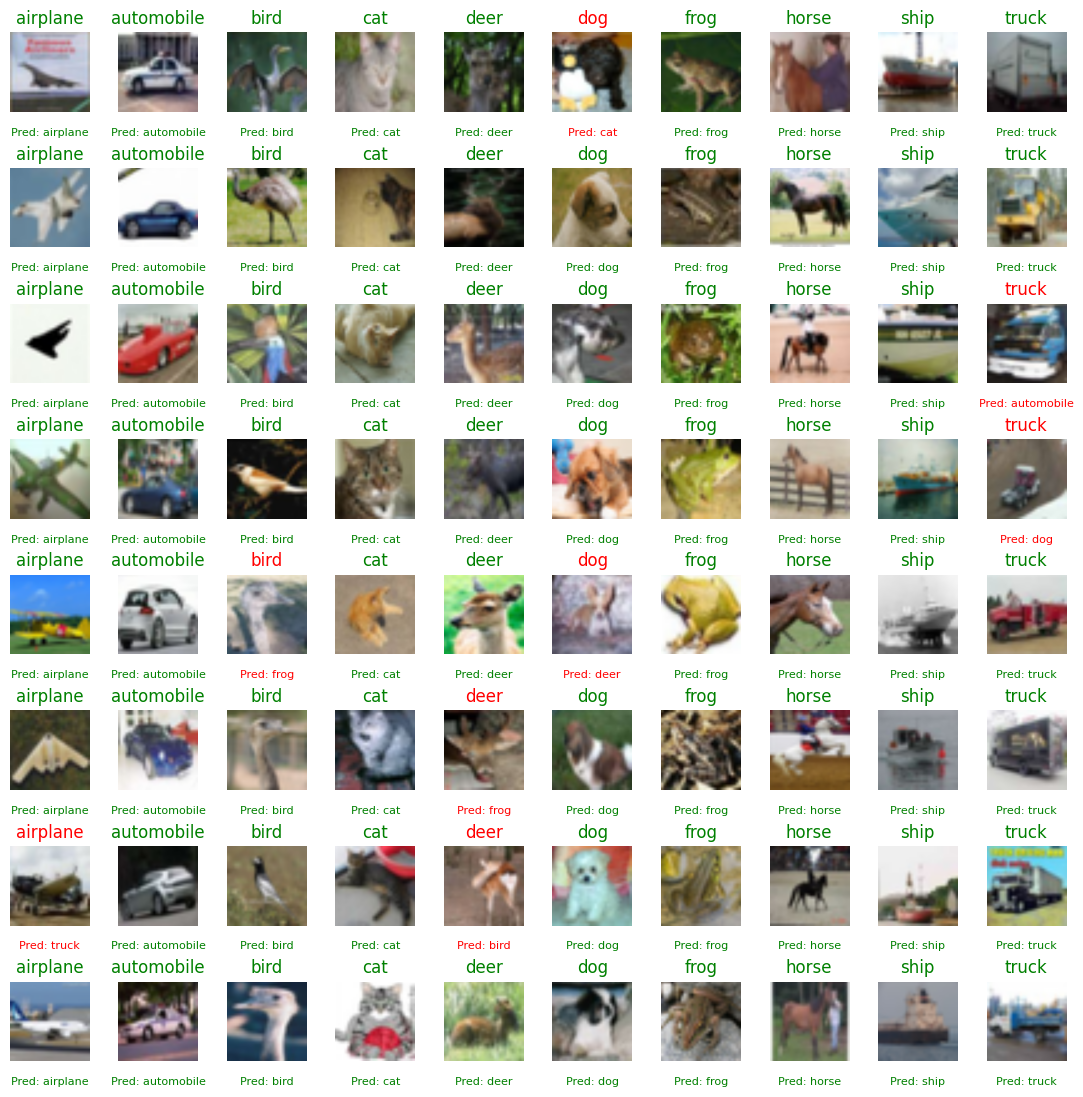

In [ ]:
n, images, categories, labels = 8, x_test, y_test, labels

# Create an image generator for the test set
test_generator = image_generator(images, categories, batch_size=1)

f, axes = plt.subplots(n, 10, figsize=(11, 11))

for i in range(10):
    count = 0
    j = 0
    while count < n:
        # Generate a batch of resized images and their corresponding labels
        x_batch, y_batch = next(test_generator)
        if y_batch[0][i] == 1:  # Check if the image belongs to the current category i
            axes[count, i].imshow(x_batch[0])
            axes[count, i].axis('off')

            # Get the model's prediction for the image
            predicted_class = np.argmax(model.predict(x_batch))

            # Compare the predicted class with the true class
            true_class = np.argmax(y_batch)  # Convert one-hot encoded category to class index

            # Set the title to display the true class label
            axes[count, i].set_title(labels[true_class], color='green' if predicted_class == true_class else 'red')

            # Set the xlabel to display the predicted class label on top of the image
            axes[count, i].text(0.5, -0.3, 'Pred: ' + labels[predicted_class],
                                color='green' if predicted_class == true_class else 'red',
                                transform=axes[count, i].transAxes, ha='center', size=8)
            count += 1
plt.tight_layout()
plt.show()

# Additional Comments

### Why Pretrained Models

- **Transfer Learning for CIFAR-10:** Pretrained models, such as those developed on expansive datasets like DenseNet201, possess extensive feature extraction capabilities. These features can be adeptly applied to similar tasks, such as our classification of the images in the CIFAR-10 dataset.

- **Efficiency in Time and Resources:** The adoption of pretrained models offers a substantial reduction in both time and computational resources. This efficiency is paramount when compared to the extensive requirements of training a model from the ground up.

### Implementation

- **Model Selection and Adaptation:** For our task, we chose the DenseNet201 model, pre-trained on the ImageNet dataset, for its architecture, feature-learning capabilities and ability to effectively recognize and categorize a wide array of images, a crucial trait for our CIFAR-10 classification project.

- **Customization:** Our implementation included custom modifications, such as adding a GlobalAveragePooling2D layer followed by a dense layer with 1024 units and a final softmax layer for class predictions, tailored specifically to the CIFAR-10 dataset's requirements.

- **Optimization for Efficiency:** By setting `base_model.trainable` to `False`, we froze the weights of the pre-trained layers, ensuring that only the weights of the newly added layers were updated during training. This approach not only expedited the training process but also reduced the computational load, making our model training more resource-efficient.

### Outcomes

- **Validation Accuracy:** After just 10 epochs of training on the CIFAR-10 dataset, our model achieved an impressive validation accuracy of 85.42%, showcasing its strong generalization capabilities with unseen data.

- **Efficacy of Transfer Learning:** Our results underscore the significant benefits of using pretrained models for image classification tasks, demonstrating that even with smaller datasets like CIFAR-10, strategic transfer learning can markedly enhance both accuracy and efficiency.